<a href="https://colab.research.google.com/github/gordoaraujo/cl_churn_prediction/blob/main/notebooks/Alaa_cl_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [170]:
!pip install --pre pycaret
!pip install "schemdraw<0.16" #<-- To handle dependency issues

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [171]:
# for some model interpretation functions
!pip install interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [172]:
from pycaret.utils import version
version()

'3.0.2'

# Load Dep. and Data

In [208]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go
import plotly.express as px

plt.rcParams["figure.figsize"] = (10, 10)  # Change matplotlib Box Size
plt.rcParams["font.size"] = 14  # Change matplotlib Font Size
#plt.style.use("fivethirtyeight")

## load Data

In [174]:
orig_url = "https://drive.google.com/file/d/1h44x4nReydrfKvwwDbXjajhDvyHUCmoz/view?usp=sharing"
file_id = orig_url.split('/')[-2]
data_path='https://drive.google.com/uc?export=download&id=' + file_id
df = pd.read_csv(data_path)

In [175]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,No,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Automatic,24.10,1734.65,No
1,Female,No,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Automatic,88.15,3973.20,No
2,Female,Yes,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Automatic,74.95,2869.85,Yes
3,Male,No,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,Male,No,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


# Data Analysis and Graphs

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   SeniorCitizen     5986 non-null   object 
 2   Partner           5986 non-null   object 
 3   Dependents        5986 non-null   object 
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   object 
 6   MultipleLines     5986 non-null   object 
 7   InternetService   5986 non-null   object 
 8   OnlineSecurity    5986 non-null   object 
 9   OnlineBackup      5986 non-null   object 
 10  DeviceProtection  5986 non-null   object 
 11  TechSupport       5986 non-null   object 
 12  StreamingTV       5986 non-null   object 
 13  StreamingMovies   5986 non-null   object 
 14  Contract          5986 non-null   object 
 15  PaperlessBilling  5986 non-null   object 
 16  PaymentMethod     5986 non-null   object 


## categorical_features

In [177]:
categorical_features = df.select_dtypes(exclude=['int', 'float']).columns

In [178]:
categorical_features

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [179]:
def crosstab_function(df, var):
    tab = pd.DataFrame(pd.crosstab(df[var], df["Churn"], margins=True)).reset_index()
    tab['Percentage'] = tab.iloc[:,2] / tab['All'] * 100
    z = []
    w = []
    for i in tab.index:
      z.append(round(tab["Yes"].iloc[i]/tab["Yes"].iloc[-1] ,4) )
      w.append(round(tab["No"].iloc[i]/tab["No"].iloc[-1] ,4) )
    tab.columns = [var, 'Churn_NO', 'Churn_YES', 'Total', 'Churn Percentage']
    tab["P(fature|Churn)"] = z
    tab["P(fature|Churn_No)"] = w
    return tab

In [180]:
#for i, column in enumerate(categorical_features):
 #   print(crosstab_function(df,column))

In [181]:
features = []
Churn_yes_perc = []
Churn_No_perc = []
for i, column in enumerate(categorical_features.drop('Churn')):
  t = crosstab_function(df,column)
  for index_row in t.index[:-1]:
    features.append(t.columns[0]+'_'+t.iloc[index_row,0])
    Churn_yes_perc.append(t.iloc[index_row,-2])
    Churn_No_perc.append(t.iloc[index_row,-1])

Churn_Cat_to_plot = pd.DataFrame()
Churn_Cat_to_plot['features'] = features
Churn_Cat_to_plot['P(feature | Churn_Yes)'] =Churn_yes_perc
Churn_Cat_to_plot['P(feature | Churn_NO)'] = Churn_No_perc
Churn_Cat_to_plot['P(F| Yes)- P(F| NO)'] = Churn_Cat_to_plot['P(feature | Churn_Yes)']- Churn_Cat_to_plot['P(feature | Churn_NO)']





In [182]:
Churn_Cat_to_plot.head()

,features,P(feature | Churn_Yes),P(feature | Churn_NO),P(F| Yes)- P(F| NO)
0,gender_Female,0.4984,0.4876,0.0108
1,gender_Male,0.5016,0.5124,-0.0108
2,SeniorCitizen_No,0.7467,0.8718,-0.1251
3,SeniorCitizen_Yes,0.2533,0.1282,0.1251
4,Partner_No,0.6371,0.4708,0.1663


In [183]:
Churn_Cat_to_plot.sort_values(by=["P(F| Yes)- P(F| NO)"],ascending=False)

,features,P(feature | Churn_Yes),P(feature | Churn_NO),P(F| Yes)- P(F| NO)
34,Contract_Month-to-month,0.8809,0.4253,0.4556
16,OnlineSecurity_No,0.7826,0.3955,0.3871
25,TechSupport_No,0.7700,0.3951,0.3749
14,InternetService_Fiber optic,0.6875,0.3492,0.3383
40,PaymentMethod_Electronic check,0.5684,0.2510,0.3174
19,OnlineBackup_No,0.6541,0.3562,0.2979
22,DeviceProtection_No,0.6497,0.3658,0.2839
38,PaperlessBilling_Yes,0.7442,0.5335,0.2107
4,Partner_No,0.6371,0.4708,0.1663
6,Dependents_No,0.8229,0.6567,0.1662


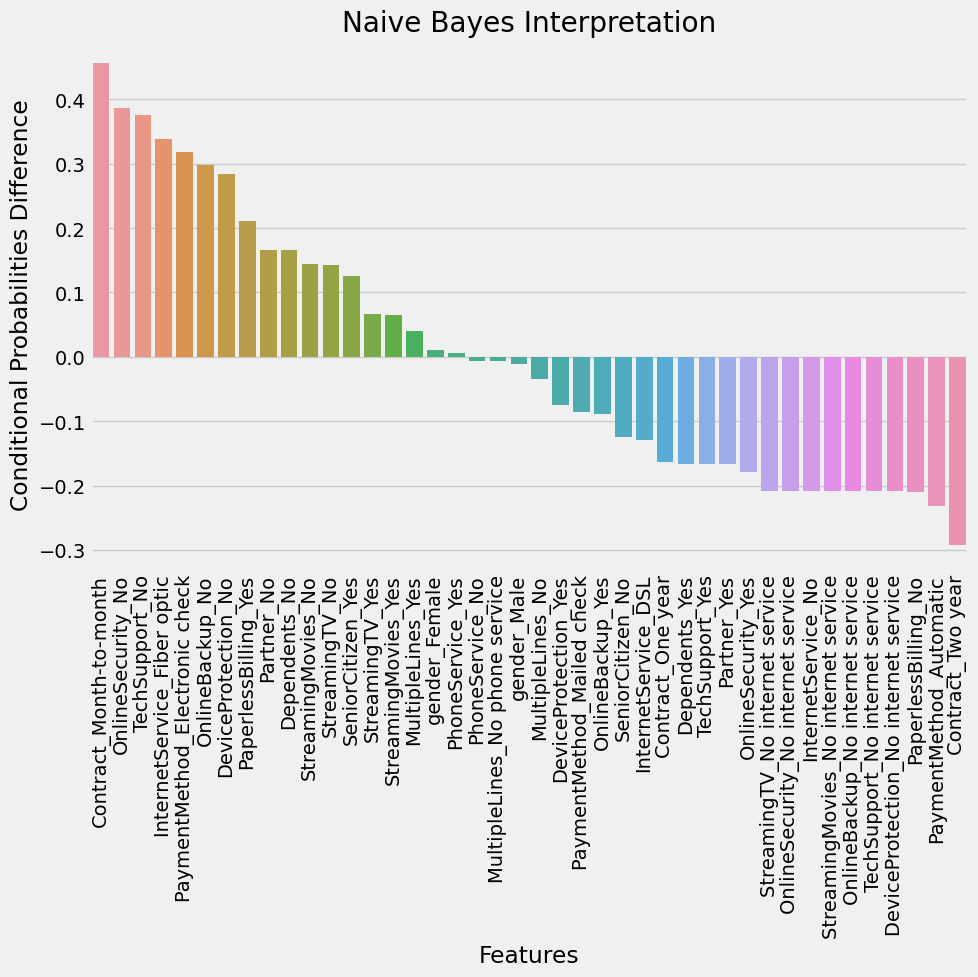

In [184]:
dC = Churn_Cat_to_plot.sort_values(by=["P(F| Yes)- P(F| NO)"],ascending=False)
#plt.figure(figsize=(20,8))
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
ax = sns.barplot(data=dC, x='features', y="P(F| Yes)- P(F| NO)")#, hue=None
ax.set(xlabel='Features', ylabel='Conditional Probabilities Difference', title='Naive Bayes Interpretation')
plt.xticks(rotation = 90); # Rotates X-Axis Ticks by 45-degrees
plt.savefig('NaiveBayesInterpretation1.png')


In [185]:
dC_imp = dC[dC["P(F| Yes)- P(F| NO)"]>0]
dC_imp

,features,P(feature | Churn_Yes),P(feature | Churn_NO),P(F| Yes)- P(F| NO)
34,Contract_Month-to-month,0.8809,0.4253,0.4556
16,OnlineSecurity_No,0.7826,0.3955,0.3871
25,TechSupport_No,0.7700,0.3951,0.3749
14,InternetService_Fiber optic,0.6875,0.3492,0.3383
40,PaymentMethod_Electronic check,0.5684,0.2510,0.3174
19,OnlineBackup_No,0.6541,0.3562,0.2979
22,DeviceProtection_No,0.6497,0.3658,0.2839
38,PaperlessBilling_Yes,0.7442,0.5335,0.2107
4,Partner_No,0.6371,0.4708,0.1663
6,Dependents_No,0.8229,0.6567,0.1662


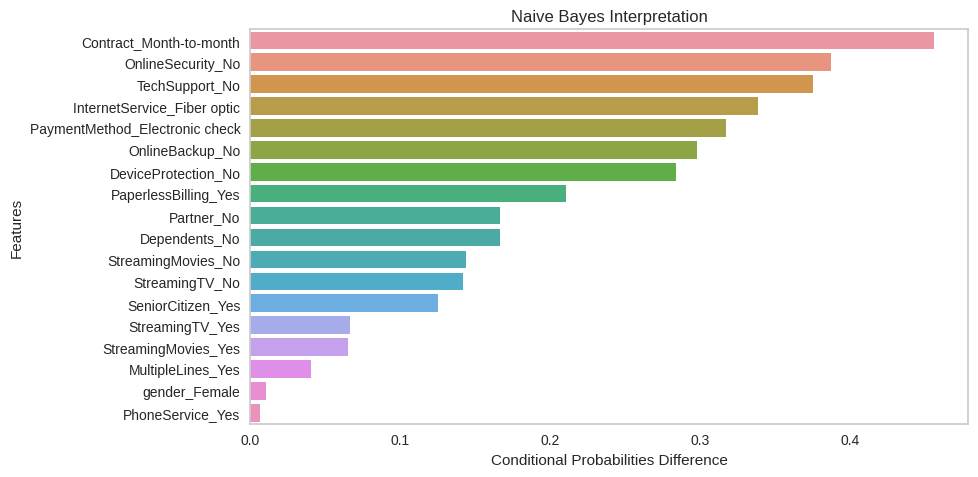

In [211]:
plt.figure(figsize=(10,5))
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
ax = sns.barplot(data=dC_imp, y='features', x="P(F| Yes)- P(F| NO)")#, hue=None
ax.set(ylabel='Features', xlabel='Conditional Probabilities Difference', title='Naive Bayes Interpretation')
#plt.xticks(rotation = 90); # Rotates X-Axis Ticks by 45-degrees
ax.grid(False)
plt.savefig('NaiveBayesInterpretation3.png',transparent=True)

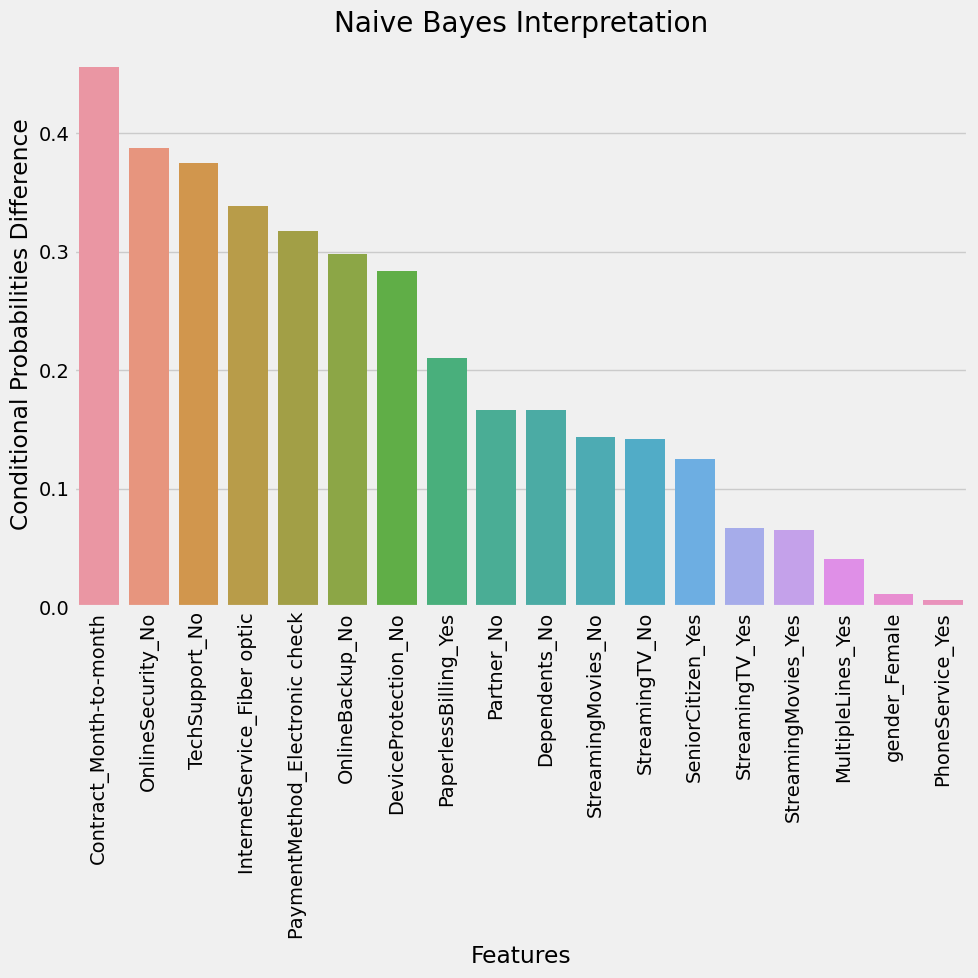

In [187]:
#plt.figure(figsize=(20,8))
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
ax = sns.barplot(data=dC_imp, x='features', y="P(F| Yes)- P(F| NO)")#, hue=None
ax.set(xlabel='Features', ylabel='Conditional Probabilities Difference', title='Naive Bayes Interpretation')
plt.xticks(rotation = 90); # Rotates X-Axis Ticks by 45-degrees
plt.savefig('NaiveBayesInterpretation2.png', transparent=True)

<Axes: >

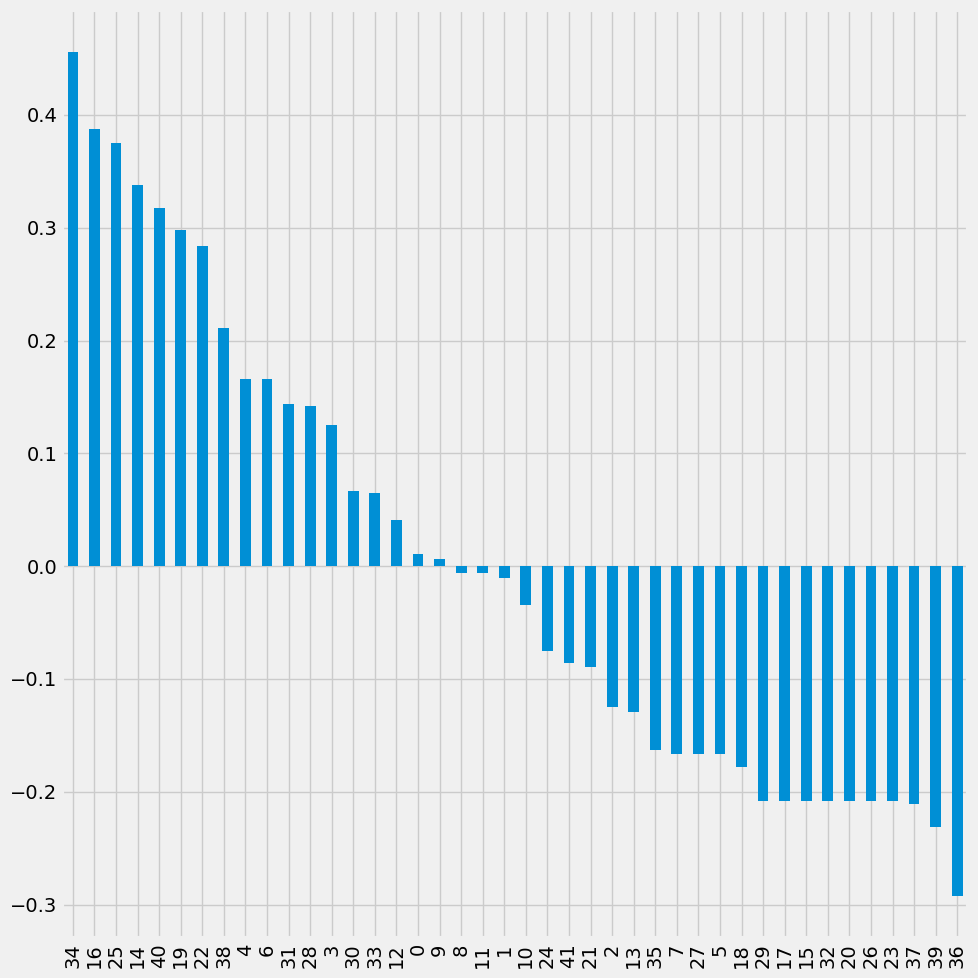

In [188]:
Churn_Cat_to_plot.sort_values(by=["P(F| Yes)- P(F| NO)"],ascending=False)["P(F| Yes)- P(F| NO)"].plot(kind='bar')

## numerical features

In [189]:
numerical_features = df.select_dtypes(include=['int', 'float']).columns
numerical_features

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

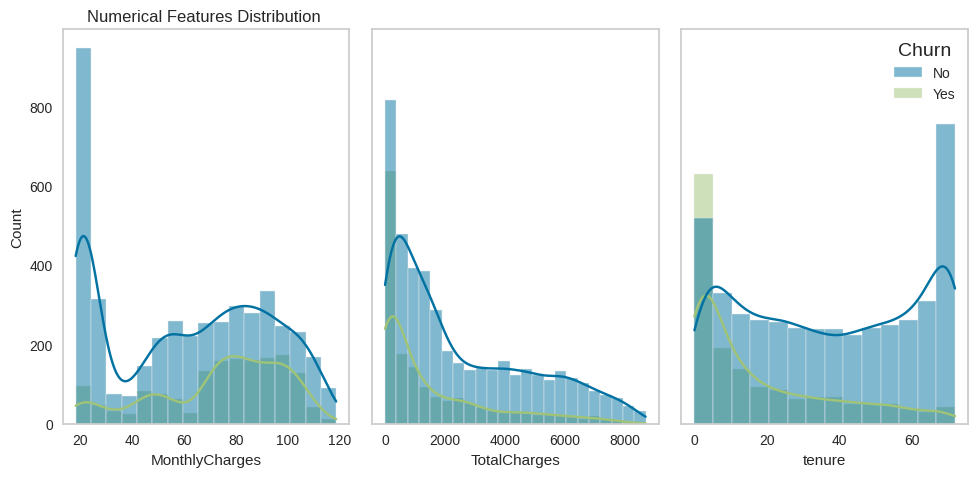

In [212]:
# Create two subplots and unpack the output array immediately
#rcParams.update({'figure.autolayout': True})
#plt.figure(figsize=(8,5))
f, ax = plt.subplots(1, 3, sharey=True, figsize=(10, 5))
(ax1, ax2,ax3) = ax
sns.histplot(data=df, x="MonthlyCharges", hue="Churn", ax = ax1,kde = True)
sns.histplot(data=df, x="TotalCharges", hue="Churn", ax = ax2,kde = True)
sns.histplot(data=df, x="tenure", hue="Churn", ax = ax3,kde = True)
ax1.set_title('Numerical Features Distribution ')
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax1.get_legend().remove()
ax2.get_legend().remove()
#lines, labels = ax3.get_legend_handles_labels()
#plt.figlegend(lines, labels, loc = 'upper center', ncol=5, labelspacing=0.)
plt.savefig('NumericalFeaturesDistribution.png', transparent=True);

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

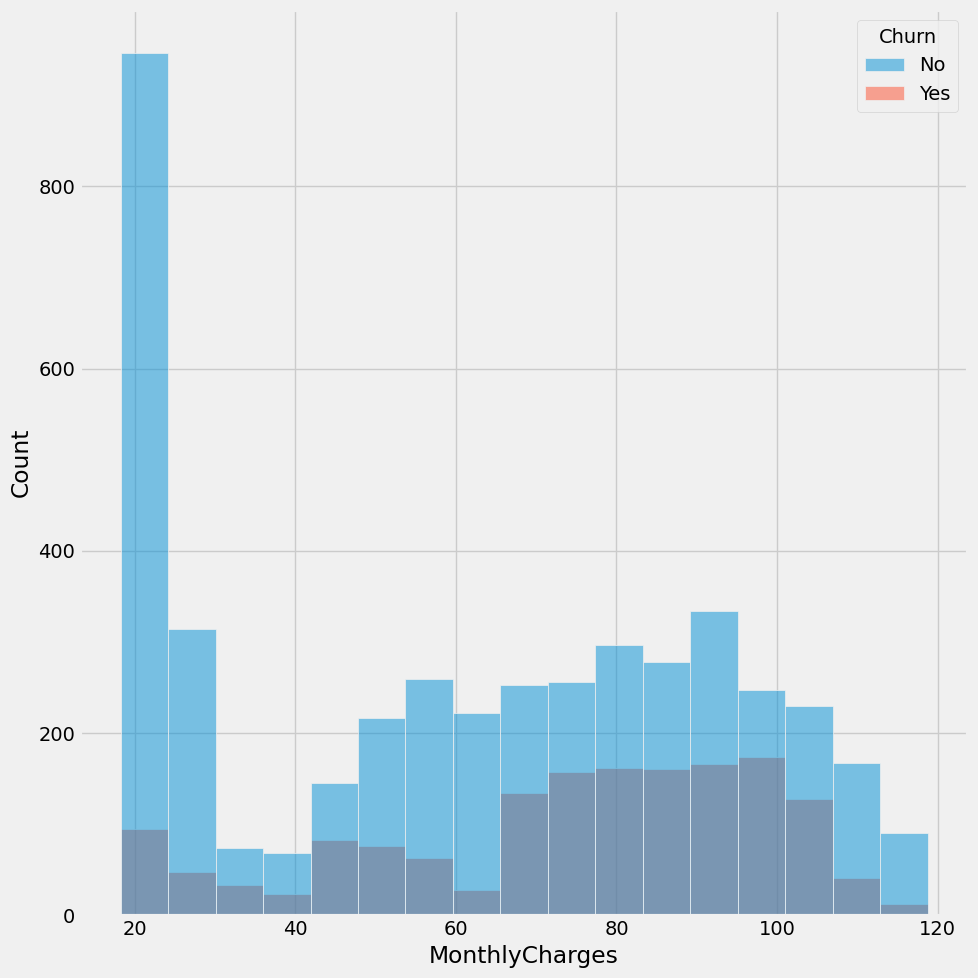

In [191]:
rcParams.update({'figure.autolayout': True})
sns.histplot(data=df, x="MonthlyCharges", hue="Churn")

# Pycaret without clustring support

In [193]:
from pycaret.classification import *

clf = setup(data=df, 
            target = 'Churn', 
            train_size = 0.8,
            session_id=13, 
            experiment_name='K_1',
            n_jobs=-1)

,Description,Value
0,Session id,13
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(5986, 20)"
5,Transformed data shape,"(5986, 40)"
6,Transformed train set shape,"(4788, 40)"
7,Transformed test set shape,"(1198, 40)"
8,Ordinal features,6
9,Numeric features,3


In [194]:
df.shape

(5986, 20)

In [195]:
# check the original data going into Pycaret
X_tr = get_config('X_train')
X_tr.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5919,Male,No,No,No,54,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,No,Automatic,87.099998,4735.200195
2581,Male,No,No,No,6,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Mailed check,80.250000,493.399994
2330,Male,No,No,No,1,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,50.750000,50.750000
5101,Male,No,No,No,11,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Automatic,20.450001,237.300003
321,Female,No,Yes,Yes,24,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Automatic,21.100000,490.649994


In [196]:
# check how pycaret transforms the data
X_tr2 = get_config('X_train_transformed')
X_tr2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_Yes,MultipleLines_No,MultipleLines_No phone service,InternetService_DSL,...,StreamingMovies_No internet service,Contract_Two year,Contract_Month-to-month,Contract_One year,PaperlessBilling,PaymentMethod_Automatic,PaymentMethod_Mailed check,PaymentMethod_Electronic check,MonthlyCharges,TotalCharges
5919,1.0,0.0,0.0,0.0,54.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,87.099998,4735.200195
2581,1.0,0.0,0.0,0.0,6.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,80.250000,493.399994
2330,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,50.750000,50.750000
5101,1.0,0.0,0.0,0.0,11.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,20.450001,237.300003
321,0.0,0.0,1.0,1.0,24.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,21.100000,490.649994


In [197]:
best_model = compare_models(fold=5, sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6851,0.8151,0.8463,0.4500,0.5876,0.3693,0.4178,0.5280
lda,Linear Discriminant Analysis,0.7957,0.8334,0.5461,0.6335,0.5863,0.4517,0.4541,1.0120
lr,Logistic Regression,0.7995,0.8410,0.5320,0.6481,0.5841,0.4538,0.4577,1.5880
ada,Ada Boost Classifier,0.8016,0.8427,0.5249,0.6563,0.5825,0.4548,0.4600,1.7760
ridge,Ridge Classifier,0.8001,0.0000,0.5123,0.6577,0.5756,0.4476,0.4538,0.9360
gbc,Gradient Boosting Classifier,0.7966,0.8426,0.5075,0.6479,0.5680,0.4380,0.4441,1.3580
qda,Quadratic Discriminant Analysis,0.6245,0.8335,0.9165,0.4089,0.5643,0.3122,0.3945,0.5180
lightgbm,Light Gradient Boosting Machine,0.7868,0.8275,0.5083,0.6186,0.5576,0.4190,0.4228,0.8900
xgboost,Extreme Gradient Boosting,0.7840,0.8164,0.5067,0.6129,0.5540,0.4134,0.4171,1.9340
rf,Random Forest Classifier,0.7884,0.8202,0.4815,0.6322,0.5465,0.4119,0.4184,1.3060


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

# Pycaret with clustering support

In [33]:
orig_url = "https://drive.google.com/file/d/1-U1Ib1T2QOkV3AWQaSkPsbDL25JCn01g/view?usp=sharing"
file_id = orig_url.split('/')[-2]
data_path='https://drive.google.com/uc?export=download&id=' + file_id
df_onehot = pd.read_csv(data_path)
df_onehot.dropna(inplace= True)

In [34]:
X_kmeans = df_onehot[[
       'cat_gender_Female', 'SeniorCitizen', 'cat_Partner_Yes',
        'cat_Dependents_Yes', 'tenure',
       'PhoneService',
       'cat_InternetService_DSL', 'cat_InternetService_Fiber optic','cat_InternetService_No',
       'cat_OnlineSecurity_No', 'cat_OnlineSecurity_Yes',
       'cat_OnlineBackup_No','cat_OnlineBackup_Yes',
        'cat_DeviceProtection_No', 'cat_DeviceProtection_Yes',
       'cat_TechSupport_No',  'cat_TechSupport_Yes',
       'cat_StreamingTV_No', 'cat_StreamingTV_Yes',
       'cat_StreamingMovies_No','cat_StreamingMovies_Yes',
       'cat_Contract_Month-to-month', 'cat_Contract_One year','cat_Contract_Two year',
       'cat_PaymentMethod_Automatic','cat_PaymentMethod_Electronic check', 'cat_PaymentMethod_Mailed check',
        'cat_PaperlessBilling_Yes', 'MonthlyCharges', 'TotalCharges'
       ]].copy()


In [35]:
from sklearn.cluster import KMeans
K_means = KMeans(n_clusters=4)
Kmeans_labels4 = K_means.fit_predict(X_kmeans)
df['Kmeans_4'] = Kmeans_labels4

In [36]:
clf = setup(data=df, 
            target = 'Churn', 
            train_size = 0.9,
            session_id=13, 
            experiment_name='K_1',
            n_jobs=-1)

,Description,Value
0,Session id,13
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(5986, 21)"
5,Transformed data shape,"(5986, 41)"
6,Transformed train set shape,"(5387, 41)"
7,Transformed test set shape,"(599, 41)"
8,Ordinal features,6
9,Numeric features,4


In [37]:
best_model = compare_models(fold=5, sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6881,0.8146,0.8438,0.4528,0.5893,0.3730,0.4201,0.5960
qda,Quadratic Discriminant Analysis,0.6893,0.8125,0.8138,0.4534,0.5815,0.3653,0.4060,0.5580
gbc,Gradient Boosting Classifier,0.8029,0.8431,0.5133,0.6677,0.5799,0.4540,0.4610,2.0780
lda,Linear Discriminant Analysis,0.7965,0.8316,0.5287,0.6432,0.5799,0.4473,0.4514,0.5580
ada,Ada Boost Classifier,0.7978,0.8399,0.5224,0.6502,0.5786,0.4477,0.4529,1.0540
lr,Logistic Regression,0.7973,0.8386,0.5203,0.6478,0.5767,0.4455,0.4504,2.7420
ridge,Ridge Classifier,0.7997,0.0000,0.4895,0.6690,0.5647,0.4386,0.4481,0.5120
lightgbm,Light Gradient Boosting Machine,0.7895,0.8281,0.5070,0.6277,0.5605,0.4243,0.4287,1.5160
rf,Random Forest Classifier,0.7908,0.8175,0.4860,0.6381,0.5516,0.4185,0.4251,1.9960
xgboost,Extreme Gradient Boosting,0.7798,0.8183,0.5035,0.6011,0.5480,0.4040,0.4068,1.5160


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

# Create model

In [198]:
nb = create_model('nb', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6785,0.8188,0.8504,0.4444,0.5838,0.3614,0.4122
1,0.6754,0.8227,0.8425,0.4412,0.5792,0.3545,0.4040
2,0.6628,0.7707,0.7913,0.4268,0.5545,0.3203,0.3601
3,0.7001,0.8172,0.8617,0.4638,0.6030,0.3951,0.4443
4,0.7085,0.8464,0.8858,0.4737,0.6173,0.4149,0.4682
Mean,0.6851,0.8151,0.8463,0.4500,0.5876,0.3693,0.4178
Std,0.0168,0.0246,0.0311,0.0167,0.0215,0.0329,0.0369


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [45]:
nb

GaussianNB(priors=None, var_smoothing=1e-09)

In [199]:
tuned_nb2 = tune_model(nb, 
                      n_iter=16, 
                      search_library='scikit-learn', 
                      search_algorithm='grid',
                      custom_grid={
                          'var_smoothing': np.logspace(0,-9, num=100)
                      },
                      optimize='f1',
                      fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7171,0.8101,0.7677,0.4791,0.5900,0.3913,0.4166
1,0.7234,0.8190,0.7835,0.4866,0.6003,0.4060,0.4330
2,0.7015,0.7819,0.7402,0.4608,0.5680,0.3582,0.3818
3,0.7356,0.8266,0.7826,0.5000,0.6102,0.4245,0.4489
4,0.7346,0.8408,0.7992,0.5000,0.6152,0.4286,0.4560
Mean,0.7224,0.8157,0.7746,0.4853,0.5967,0.4017,0.4273
Std,0.0126,0.0197,0.0199,0.0146,0.0168,0.0255,0.0265


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [205]:
tuned_nb = tune_model(nb, 
                      n_iter=16, 
                      search_library='scikit-learn', 
                      search_algorithm='random',
                      custom_grid={
                          'var_smoothing': np.logspace(0,-9, num=100)
                      },
                      optimize='f1',
                      fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7171,0.8101,0.7677,0.4791,0.5900,0.3913,0.4166
1,0.7234,0.8190,0.7835,0.4866,0.6003,0.4060,0.4330
2,0.7015,0.7819,0.7402,0.4608,0.5680,0.3582,0.3818
3,0.7356,0.8266,0.7826,0.5000,0.6102,0.4245,0.4489
4,0.7346,0.8408,0.7992,0.5000,0.6152,0.4286,0.4560
Mean,0.7224,0.8157,0.7746,0.4853,0.5967,0.4017,0.4273
Std,0.0126,0.0197,0.0199,0.0146,0.0168,0.0255,0.0265


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [201]:
tuned_nb2

GaussianNB(priors=None, var_smoothing=1.519911082952933e-07)

In [207]:
plot_model(tuned_nb, save=True)

'AUC.png'

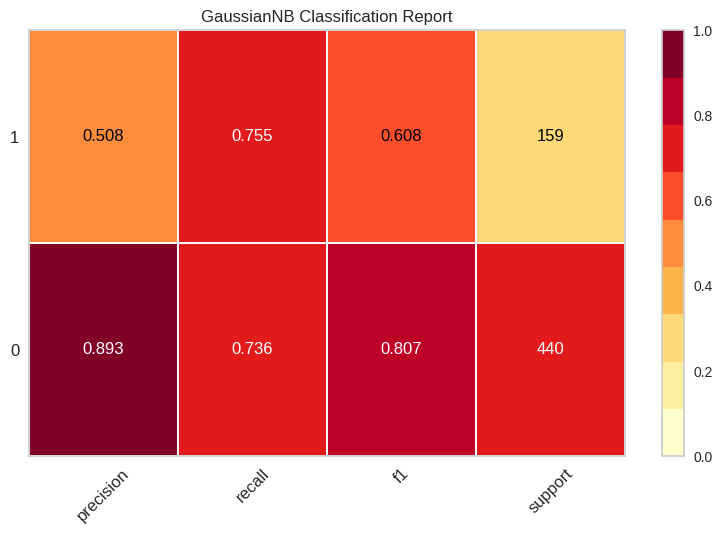

In [54]:
plot_model(tuned_nb, plot='class_report')

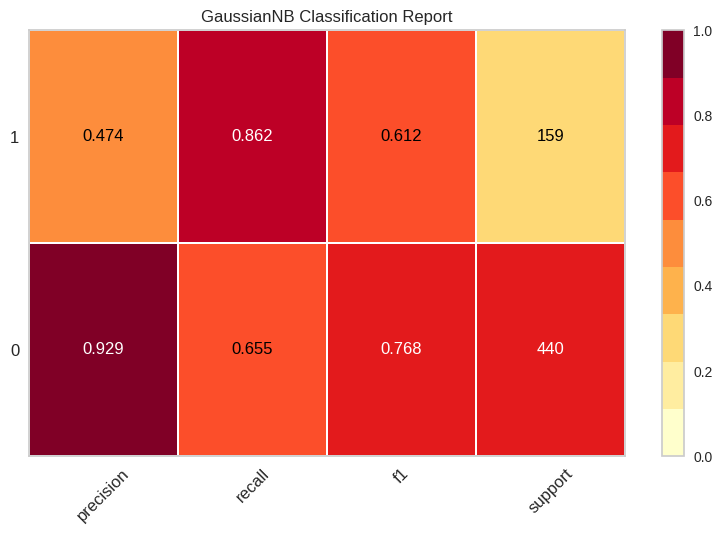

In [51]:
plot_model(nb, plot='class_report')

In [56]:
predict_model(nb)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7095,0.8270,0.8616,0.4740,0.6116,0.4093,0.4561


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,prediction_label,prediction_score
5286,Female,No,Yes,Yes,65,Yes,Yes,No,No internet service,No internet service,...,No internet service,No internet service,Two year,No,Automatic,26.000000,1654.849976,0,No,1.0000
1817,Female,No,Yes,Yes,22,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,No,Mailed check,61.150002,1422.050049,1,No,0.6029
4337,Male,No,Yes,Yes,13,Yes,No,DSL,Yes,No,...,No,No,Month-to-month,Yes,Mailed check,49.950001,587.450012,0,Yes,0.9828
5268,Male,No,No,No,1,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Month-to-month,Yes,Automatic,20.200001,20.200001,1,No,1.0000
5010,Male,No,Yes,No,22,Yes,No,Fiber optic,No,No,...,Yes,No,Month-to-month,Yes,Automatic,87.000000,1850.650024,0,Yes,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833,Male,Yes,Yes,Yes,8,Yes,No,Fiber optic,No,No,...,Yes,No,Month-to-month,Yes,Automatic,80.449997,583.450012,1,Yes,1.0000
5108,Female,No,Yes,Yes,23,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Automatic,75.300003,1702.900024,0,Yes,0.9998
3440,Female,No,Yes,No,24,Yes,Yes,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Mailed check,79.650002,1928.699951,0,Yes,1.0000
3381,Male,No,Yes,No,49,Yes,Yes,DSL,Yes,No,...,Yes,Yes,One year,No,Electronic check,84.349998,4059.350098,1,No,0.9988


In [55]:
predict_model(tuned_nb) # check performance on the 10% held out data from train

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7412,0.8313,0.7547,0.5085,0.6076,0.4253,0.4438


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,prediction_label,prediction_score
5286,Female,No,Yes,Yes,65,Yes,Yes,No,No internet service,No internet service,...,No internet service,No internet service,Two year,No,Automatic,26.000000,1654.849976,0,No,0.9964
1817,Female,No,Yes,Yes,22,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,No,Mailed check,61.150002,1422.050049,1,No,0.5389
4337,Male,No,Yes,Yes,13,Yes,No,DSL,Yes,No,...,No,No,Month-to-month,Yes,Mailed check,49.950001,587.450012,0,Yes,0.6533
5268,Male,No,No,No,1,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Month-to-month,Yes,Automatic,20.200001,20.200001,1,No,0.8622
5010,Male,No,Yes,No,22,Yes,No,Fiber optic,No,No,...,Yes,No,Month-to-month,Yes,Automatic,87.000000,1850.650024,0,Yes,0.7805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833,Male,Yes,Yes,Yes,8,Yes,No,Fiber optic,No,No,...,Yes,No,Month-to-month,Yes,Automatic,80.449997,583.450012,1,Yes,0.8862
5108,Female,No,Yes,Yes,23,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Automatic,75.300003,1702.900024,0,Yes,0.7466
3440,Female,No,Yes,No,24,Yes,Yes,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Mailed check,79.650002,1928.699951,0,Yes,0.7915
3381,Male,No,Yes,No,49,Yes,Yes,DSL,Yes,No,...,Yes,Yes,One year,No,Electronic check,84.349998,4059.350098,1,No,0.8878
